In [1]:
import sys
sys.path.append('../')

In [9]:
from torchdyn.models import *
from torchdyn import *
from torchdyn.datasets import *

import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
## nonlinear conservative vector field
class func(nn.Module):
    def __init__(self, sys):
        super().__init__()
        
    def forward(self, x):
        dxdt =  x[:,1]
        dydt =  1*np.pi*torch.cos(np.pi*x[:,0]-np.pi/2) - np.pi*x[:,0] - .5*np.pi*x[:,1]
        return torch.cat([dxdt[:,None], dydt[:,None]], 1)

In [11]:
def sys(x):
    x, y = x[:,0], x[:,1]
    dxdt = -y + x*(1 - x**2 - y**2)
    dydt =  x + y*(1 - x**2 - y**2)
    return torch.cat([dxdt[:,None], dydt[:,None]], 1)

qqq

$$    
    \begin{bmatrix}
        \dot x\\
        \dot v
    \end{bmatrix} =
    \begin{bmatrix}
        v(t)\\
        \pi\left[\cos\left(\pi x(t) - \frac{\pi}{2}\right) - x(t)\right]
    \end{bmatrix} 
$$


In [12]:

## nonlinear conservative vector field
class func(nn.Module):
    def __init__(self, sys):
        super().__init__()
        self.sys = sys
        
    def forward(self, x):
        return self.sys(x)

In [13]:
system = NeuralDE(func(sys))

t_span = torch.linspace(0, 2, 100)
x0 = torch.randn(1000,2)

traj = system.trajectory(x0, t_span)

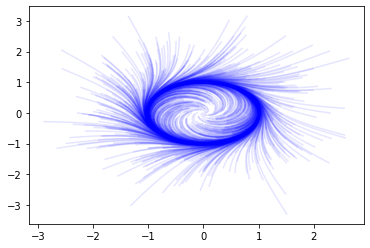

In [14]:
for i in range(len(x0)):
    plt.plot(traj[:,i,0], traj[:,i,1], color='blue', alpha=.1)

In [15]:
vf = func(sys)
X = 4*torch.rand(20000,2).to(device)
y = vf(X)
train = data.TensorDataset(X, y)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

In [16]:
# import torch.utils.data as data
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# t = torch.linspace(0,1, 100).reshape(-1,1)
# X = torch.cat([
#     torch.sin(2*np.pi*t),
#     torch.cos(2*np.pi*t)
# ],1).to(device)

# y = torch.cat([
#     torch.cos(2*np.pi*t),
#     -torch.sin(2*np.pi*t)
# ],1).to(device)

# train = data.TensorDataset(X, y)
# trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

In [17]:
import pytorch_lightning as pl

class HNNLearner(pl.LightningModule):
    def __init__(self, model:nn.Module, settings:dict={}):
        super().__init__()
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model.defunc(0,x)
    
    def loss(self, y, y_hat):
        return ((y-y_hat)**2).sum(1).mean()
    
    def training_step(self, batch, batch_idx):
        #x, y = batch    
        x = torch.randn(20000,2).to(device)
        y = vf(x)
        y_hat = self.model.defunc(0,x)   
        loss = self.loss(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train_dataloader(self):
        return trainloader

In [41]:
class Stable(nn.Module):
    """Stable Neural Flow"""
    def __init__(self, net, depthvar=False, controlled=False):
        super().__init__()
        self.net, self.depthvar, self.controlled = net, depthvar, controlled
        self.Ms = torch.nn.Parameter(torch.randn(1,2)).to(device)
        self.Ma = torch.nn.Parameter(torch.randn(2,2)).to(device)
    
    def Askew(self):
        return .5*(self.Ma - self.Ma.T)
    
    def Asym(self):
        return .5*(self.Ms + self.Ms.T)

    def forward(self, x):
        with torch.set_grad_enabled(True):
            bs, n = x.shape[0], x.shape[1] // 2
            x = x.requires_grad_(True)
            eps = self.net(x).sum()
            out = -torch.autograd.grad(eps, x, allow_unused=False, create_graph=True)[0] 
            #self.out = out
        out = out[:,:-1] if self.depthvar else out
        out = out[:,:-2] if self.controlled else out
        return out *self.Ms # @ (self.Askew() + self.Ms.diag_embed())

In [42]:
# vector field parametrized by a NN
h_dim = 128
f = Stable(nn.Sequential(
                  nn.Linear(2,h_dim),
                  nn.Tanh(), 
                  nn.Linear(h_dim,h_dim),
                  nn.Tanh(), 
                  nn.Linear(h_dim,h_dim),
                  nn.Tanh(),
                  nn.Linear(h_dim,h_dim),
                  nn.Tanh(),
                  nn.Linear(h_dim, 1)))            

# neural ODE
model = NeuralDE(f, 
                 order=1,
                 solver='dopri5', 
                 sensitivity='adjoint').to(device)
seq = nn.Sequential(model, nn.Linear(2,2,bias=False)).to(device)

In [43]:
learn = HNNLearner(model)
trainer = pl.Trainer(min_nb_epochs=500, max_nb_epochs=1000)
trainer.fit(learn)

INFO:lightning:
   | Name                 | Type       | Params
------------------------------------------------
0  | model                | NeuralDE   | 50 K  
1  | model.defunc         | DEFunc     | 50 K  
2  | model.defunc.m       | Stable     | 50 K  
3  | model.defunc.m.net   | Sequential | 50 K  
4  | model.defunc.m.net.0 | Linear     | 384   
5  | model.defunc.m.net.1 | Tanh       | 0     
6  | model.defunc.m.net.2 | Linear     | 16 K  
7  | model.defunc.m.net.3 | Tanh       | 0     
8  | model.defunc.m.net.4 | Linear     | 16 K  
9  | model.defunc.m.net.5 | Tanh       | 0     
10 | model.defunc.m.net.6 | Linear     | 16 K  
11 | model.defunc.m.net.7 | Tanh       | 0     
12 | model.defunc.m.net.8 | Linear     | 129   
13 | model.adjoint        | Adjoint    | 0     


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


1

Text(0.5, 1.0, 'Nominal')

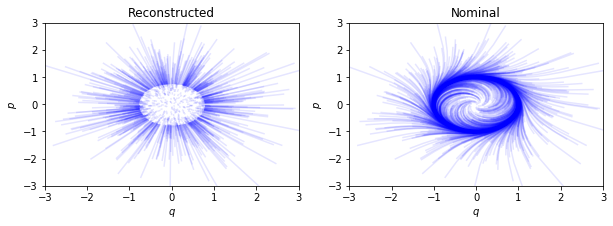

In [39]:
# Sample random initial conditions
X_t = torch.randn(1000, 2).to(device)
# Evaluate the HNN trajectories for 1s
s_span = torch.linspace(0, 5, 100)
traj = model.trajectory(X_t, s_span).detach().cpu()
sys_traj = system.trajectory(X_t, s_span).detach().cpu()

# Plot the HHN's trajectories with random ICs
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(len(X_t)):
    ax.plot(traj[:,i,0], traj[:,i,1], color='blue', alpha=0.1);
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("Reconstructed")


for i in range(len(X_t)):
    ax2.plot(sys_traj[:,i,0], sys_traj[:,i,1], color='blue', alpha=0.1);
ax2.set_xlim([-3,3])
ax2.set_ylim([-3,3])
ax2.set_xlabel(r"$q$")
ax2.set_ylabel(r"$p$")
ax2.set_title("Nominal")

Text(0.5, 1.0, 'Learned Hamiltonian & Vector Field')

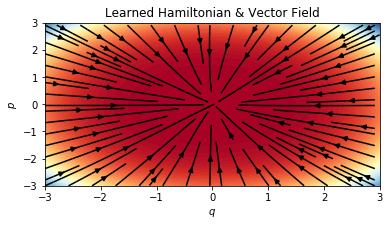

In [40]:
n_grid =  50
x = torch.linspace(-3,3,n_grid)
Q, P = torch.meshgrid(x,x)
H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)
for i in range(n_grid):
    for j in range(n_grid):
        x = torch.cat([Q[i,j].reshape(1,1),P[i,j].reshape(1,1)],1).to(device)
        H[i,j] = model.defunc.m.net(x).detach().cpu()
        O = model.defunc(0,x).detach().cpu()
        U[i,j], V[i,j] = O[0,0], O[0,1]
        
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.contourf(Q,P,H,100,cmap='RdYlBu')
ax.streamplot(Q.T.numpy(),P.T.numpy(),U.T.numpy(),V.T.numpy(), color='black')
ax.set_xlim([Q.min(),Q.max()])
ax.set_ylim([P.min(),P.max()])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("Learned Hamiltonian & Vector Field")

# Nonlinear Classification


**Data:** we use again the moons dataset (with some added noise) simply because all the models will be effective to solve the binary classification problem.



In [3]:
d = ToyDataset()
X, yn = d.generate(n_samples=512, dataset_type='moons', noise=.2)

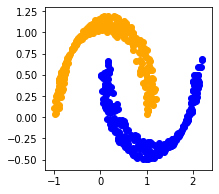

In [4]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

In [5]:


X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

**Learner**

In [6]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, settings:dict={}):
        super().__init__()
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        y_hat = self.model(x)  
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.005)

    def train_dataloader(self):
        return trainloader

In [7]:
from torch.autograd import grad as grad

In [8]:
import pdb
class intloss(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
    def forward(self, x):
        #x.requires_grad_(True)
        loss = 1e-4*torch.abs(self.f(x)).sum(1) #grad(self.f(s, x), x, create_graph=True
        return loss

In [9]:
class Stable(nn.Module):
    """Stable Neural Flow"""
    def __init__(self, net, depthvar=False, controlled=False):
        super().__init__()
        self.net, self.depthvar, self.controlled = net, depthvar, controlled
        self.M = torch.nn.Parameter(0.001*torch.randn(2,2)).to(device)
    
    def Askew(self):
        return .5*(self.M - self.M.T)

    def forward(self, x):
        with torch.set_grad_enabled(True):
            bs, n = x.shape[0], x.shape[1] // 2
            x = x.requires_grad_(True)
            eps = self.net(x).sum()
            out = -torch.autograd.grad(eps, x, allow_unused=False, create_graph=True)[0] 
            #self.out = out
        out = out[:,:-1] if self.depthvar else out
        out = out[:,:-2] if self.controlled else out
        return out @ self.Askew()

In [10]:
# vector field parametrized by a NN
f = Stable(nn.Sequential(
                  nn.Linear(2, 64),
                  nn.Tanh(), 
                  nn.Linear(64, 1)))
                  

# neural ODE
model = NeuralDE(f, 
                 order=1,
                 solver='dopri5', 
                 sensitivity='adjoint', 
                 intloss=intloss(f)).to(device)
seq = nn.Sequential(model, nn.Linear(2,2,bias=False)).to(device)

In [11]:
# boh = DEFunc(f, order=1, controlled=False)

# x = torch.randn(10, 2, requires_grad=False)

# x = x.requires_grad_(True)

# b = boh( torch.zeros(1),x.cuda(),)
# torch.autograd.grad(b.sum(), x)

# train the neural ODE
learn = Learner(seq)
trainer = pl.Trainer(min_nb_epochs=300, max_nb_epochs=600)
trainer.fit(learn)

INFO:lightning:
   | Name                   | Type       | Params
--------------------------------------------------
0  | model                  | Sequential | 261   
1  | model.0                | NeuralDE   | 257   
2  | model.0.defunc         | DEFunc     | 257   
3  | model.0.defunc.m       | Stable     | 257   
4  | model.0.defunc.m.net   | Sequential | 257   
5  | model.0.defunc.m.net.0 | Linear     | 192   
6  | model.0.defunc.m.net.1 | Tanh       | 0     
7  | model.0.defunc.m.net.2 | Linear     | 65    
8  | model.0.intloss        | intloss    | 257   
9  | model.0.adjoint        | Adjoint    | 257   
10 | model.1                | Linear     | 4     


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)
INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1

**Plots**

In [12]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

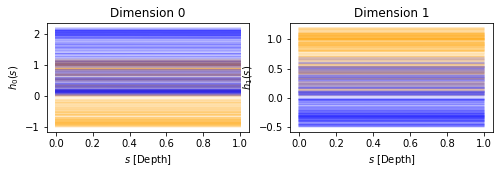

In [13]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

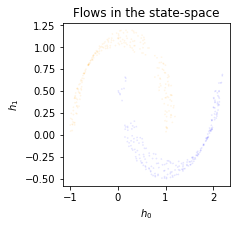

In [14]:
plot_2D_state_space(trajectory, yn, 512)

Text(0.5, 1.0, 'Learned Hamiltonian & Vector Field')

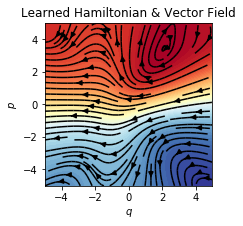

In [15]:
n_grid =  50
x = torch.linspace(-5,5,n_grid)
Q, P = torch.meshgrid(x,x)
H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)
for i in range(n_grid):
    for j in range(n_grid):
        x = torch.cat([Q[i,j].reshape(1,1),P[i,j].reshape(1,1)],1).to(device)
        H[i,j] = model.defunc.m.net(x).detach().cpu()
        O = model.defunc(0,x).detach().cpu()
        U[i,j], V[i,j] = O[0,0], O[0,1]
        
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.contourf(Q,P,H,100,cmap='RdYlBu')
ax.streamplot(Q.T.numpy(),P.T.numpy(),U.T.numpy(),V.T.numpy(), color='black')
ax.set_xlim([Q.min(),Q.max()])
ax.set_ylim([P.min(),P.max()])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("Learned Hamiltonian & Vector Field")

In [16]:
model.defunc.m.Askew()

tensor([[ 0.0000,  0.0005],
        [-0.0005,  0.0000]], device='cuda:0', grad_fn=<MulBackward0>)

In [32]:
x.diag_embed()

tensor([[[3., 0.],
         [0., 3.]]], device='cuda:0', grad_fn=<CopySlices>)